In [ ]:
import os
import sys

#import heuristic model files

hm_files_path = os.path.join(os.path.dirname(os.getcwd()), 'Heuristic_model')
print(hm_files_path)

if hm_files_path in sys.path:
    pass
else:
    sys.path.append(hm_files_path)


In [1]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import analyse_each_rep, find_extremas, filter_extremas, numpy_fillna
from Evaluation import triceps_pushdown_evaluation
from JointAngles import JointAngles
import numpy as np
import glob
import pickle
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


C:\Users\kvash\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
input_folder = "C:\\Users\\kvash\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\triceps_pushdown"
#input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\triceps_pushdown'
folder_paths = glob.glob(os.path.join(input_folder, 'triceps_pushdown*'))
points_folder_name = os.path.basename(input_folder)


def get_data_for_dataset(folder_paths, points_folder_name):
    angle_label_dict = {}
    data = {}
    # need to have a dict with keys : uf_points, ut_points, tk_points; where dict[key] = [([p], 0/1)]; append(([p], 0/1))
    #labeled_arrays = {0:[()], 1:[()]}
    angle_arrays = []
    uf_labels, ut_labels, tk_labels = [], [], []
    if points_folder_name == 'triceps_pushdown': 
        for folder in folder_paths:
            video_name = os.path.basename(folder)
            frame_poses = parse_frames(folder)
            joint_angles = JointAngles(points_folder_name, frame_poses)


            upArm_forearm_angles = np.array(joint_angles.upArm_forearm_angles)
            upArm_forearm_angles = np.nan_to_num(upArm_forearm_angles)
            upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_forearm_angles_filtered)

            upArm_trunk_angles = np.array(joint_angles.upArm_trunk_angles)
            upArm_trunk_angles = np.nan_to_num(upArm_trunk_angles)
            upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_trunk_angles_filtered)

            trunk_knee_angles = np.array(joint_angles.trunk_knee_angles)
            trunk_knee_angles = np.nan_to_num(trunk_knee_angles)
            trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (trunk_knee_angles_filtered)

            #number of reps 
            extremas = filter_extremas(upArm_forearm_angles_filtered, find_extremas(upArm_forearm_angles_filtered, maxima=False), maxima=False) 
            
            uf_angles, ut_angles, tk_angles = analyse_each_rep(points_folder_name, 'dataset', extremas, upArm_forearm_angles_filtered, upArm_trunk_angles_filtered, trunk_knee_angles_filtered)
            for uf, ut, tk in zip(uf_angles, ut_angles, tk_angles):
                # start position
                if 109 > uf[:1][0] >= 62 and np.max(uf) >= 150 and 109 > uf[-1:][0] >= 62:
                    uf_labels.append(0)
                else:
                    uf_labels.append(1)
                    
                if ut[:1][0] < 24 and np.max(ut) < 24 and ut[-1:][0] < 24:
                    ut_labels.append(0)
                else:
                    ut_labels.append(1)
                    
                if 150 <= tk[:1][0] < 195 and np.min(tk) >= 150 and 150 <= np.max(tk) < 195 and 150 <= tk[-1:][0] < 195:
                    tk_labels.append(0)
                else:
                    tk_labels.append(1)
                
            angle_arrays.append(([uf_labels, ut_labels, tk_labels], extremas, [uf_angles, ut_angles, tk_angles]))
            # erase labels to store new labels         
            uf_labels, ut_labels, tk_labels = [], [], []
  

    else: 
        print('Error: Wrong folder path! Has to be: triceps pushdown')

    return angle_arrays
                                             
                                    

def fill_dataframe(angle_arrays, exercise_folder_name):
    df_tup = (None,None,None)
    
    print('Filling dataset with ' + str(exercise_folder_name) + ' data...')
   
    for tup in angle_arrays:
        labels = tup[0]
        extremas = tup[1]
        uf, ut, tk = tup[2]

        # Extract rep angles
        #print(len(uf), len(ut), len(tk))
        s1 = pd.Series(uf, name='Angle_array')
        s1a = pd.Series(labels[0], name='Label')
        df1 = pd.concat([s1,s1a], axis=1)
               
        s2 = pd.Series(ut, name='Angle_array')
        s2a = pd.Series(labels[1], name='Label')
        df2 = pd.concat([s2,s2a], axis=1)
        
        s3 = pd.Series(tk, name='Angle_array')
        s3a = pd.Series(labels[2], name='Label')
        df3 = pd.concat([s3,s3a], axis=1)
               
        df_tup = (pd.concat([df_tup[0],df1]), pd.concat([df_tup[1], df2]), pd.concat([df_tup[2],df3]))
        #pd.concat(df_list).reset_index(drop=True)

    return df_tup


        

In [3]:
#filter uf_df
def filter_uf_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] > 120 or x[-1:][0] > 120 or (x[:1][0] > 120 and x[-1:][0] > 120): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            hm = {}
            print(len(ls_1) == len(ls_2))           
                     
            for i, j in zip(ls_1, ls_2):
                #print(i,j)
                if np.array_equal(j,x):
                    #print(i,x)
                    idx_ls.append(i)
                    print('Deleted entry', i)
    df = df.drop(idx_ls)
        
    return df 

#filter ut_df
def filter_ut_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] > 25 or x[-1:][0] > 25 or (x[:1][0] > 25 and x[-1:][0] > 25): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
                                 
            for i, j in zip(ls_1, ls_2):
                #print(i,j)
                if np.array_equal(j,x):
                    #print(i,x)
                    idx_ls.append(i)
                    print('Deleted entry', i)
    df = df.drop(idx_ls)
        
    return df 

#filter tk_df
def filter_tk_df(vals, df):
    idx_ls = []
    for x in vals:
        if x[:1][0] < 140 or x[-1:][0] < 140 or (x[:1][0] < 140 and x[-1:][0] < 140): 
            #print(x)
            ls_1 = df['Angle_array'].index.tolist()
            ls_2 = df['Angle_array'].values.tolist()
            #print(len(ls_1) == len(ls_2))           
                     
            for i, j in zip(ls_1, ls_2):
                #print(i,j)
                if np.array_equal(j,x):
                    #print(i,x)
                    idx_ls.append(i)
                    print('Deleted entry', i)
                    
    df = df.drop(idx_ls)
        
    return df 


In [3]:
angle_arrays = get_data_for_dataset(folder_paths, points_folder_name) 
df_tup = fill_dataframe(angle_arrays, points_folder_name)


Filling dataset with triceps_pushdown data...


In [4]:
pd.concat([df_tup[0], df_tup[1], df_tup[2]]).reset_index(drop=True).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877 entries, 0 to 2876
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  2877 non-null   object
 1   Label        2877 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.1+ KB


# Filter dataframes with correct reps

In [5]:
df_tup[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 12
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  959 non-null    object
 1   Label        959 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 22.5+ KB


In [145]:
uf_df = df_tup[0]

In [146]:
uf_df_good = uf_df[uf_df.Label == 0].reset_index(drop=True)
print(uf_df_good.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  613 non-null    object
 1   Label        613 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.7+ KB
None


In [147]:
uf_df_bad = uf_df[uf_df.Label == 1].reset_index(drop=True)
print(uf_df_bad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  346 non-null    object
 1   Label        346 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ KB
None


In [148]:
ut_df = df_tup[1]
ut_df_good = ut_df[ut_df.Label == 0].reset_index(drop=True)
print(ut_df_good.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  564 non-null    object
 1   Label        564 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.9+ KB
None


In [149]:
ut_df_bad = ut_df[ut_df.Label == 1].reset_index(drop=True)
print(ut_df_bad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  395 non-null    object
 1   Label        395 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.3+ KB
None


In [150]:
tk_df = df_tup[2]
tk_df_good = tk_df[tk_df.Label == 0].reset_index(drop=True)
print(tk_df_good.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  805 non-null    object
 1   Label        805 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.7+ KB
None


In [151]:
tk_df_bad = tk_df[tk_df.Label == 1].reset_index(drop=True)
print(tk_df_bad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  154 non-null    object
 1   Label        154 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ KB
None


In [152]:
df = pd.concat([df_tup[0], df_tup[1], df_tup[2]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 12
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  2877 non-null   object
 1   Label        2877 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.4+ KB


In [153]:
x_test, y_test = [], []

In [154]:
for m in range(140):
    x_test.append(uf_df_good.Angle_array[m])
    y_test.append(uf_df_good.Label[m])
    uf_df_good = uf_df_good.drop(m)

In [155]:
for m in range(140):
    x_test.append(uf_df_bad.Angle_array[m])
    y_test.append(uf_df_bad.Label[m])
    uf_df_bad = uf_df_bad.drop(m)

In [156]:
for m in range(140):
    x_test.append(ut_df_good.Angle_array[m])
    y_test.append(ut_df_good.Label[m])
    ut_df_good = ut_df_good.drop(m)

In [157]:
for m in range(140):
    x_test.append(ut_df_bad.Angle_array[m])
    y_test.append(ut_df_bad.Label[m])
    ut_df_bad = ut_df_bad.drop(m)

In [158]:
for m in range(222):
    x_test.append(tk_df_good.Angle_array[m])
    y_test.append(tk_df_good.Label[m])
    tk_df_good = tk_df_good.drop(m)

In [159]:
for m in range(79):
    x_test.append(tk_df_bad.Angle_array[m])
    y_test.append(tk_df_bad.Label[m])
    tk_df_bad = tk_df_bad.drop(m)

In [160]:
len(x_test)

861

In [161]:
#correct reps dataframe
df_good = pd.concat([uf_df_good, ut_df_good, tk_df_good]).reset_index(drop=True)
df_bad = pd.concat([uf_df_bad, ut_df_bad, tk_df_bad]).reset_index(drop=True)

In [162]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  1480 non-null   object
 1   Label        1480 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.2+ KB


In [163]:
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  536 non-null    object
 1   Label        536 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ KB


In [3]:
#correct reps dataframe
df_good = pickle.load( open( "datasets/triceps_df_good.pickle", "rb" ) )

df_good.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  1892 non-null   object
 1   Label        1892 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.7+ KB


In [10]:
df_bad = pickle.load( open( "datasets/triceps_df_bad.pickle", "rb" ) )
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  685 non-null    object
 1   Label        685 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.8+ KB


# Clustering


In [11]:
series = df_good.Angle_array.values.tolist()

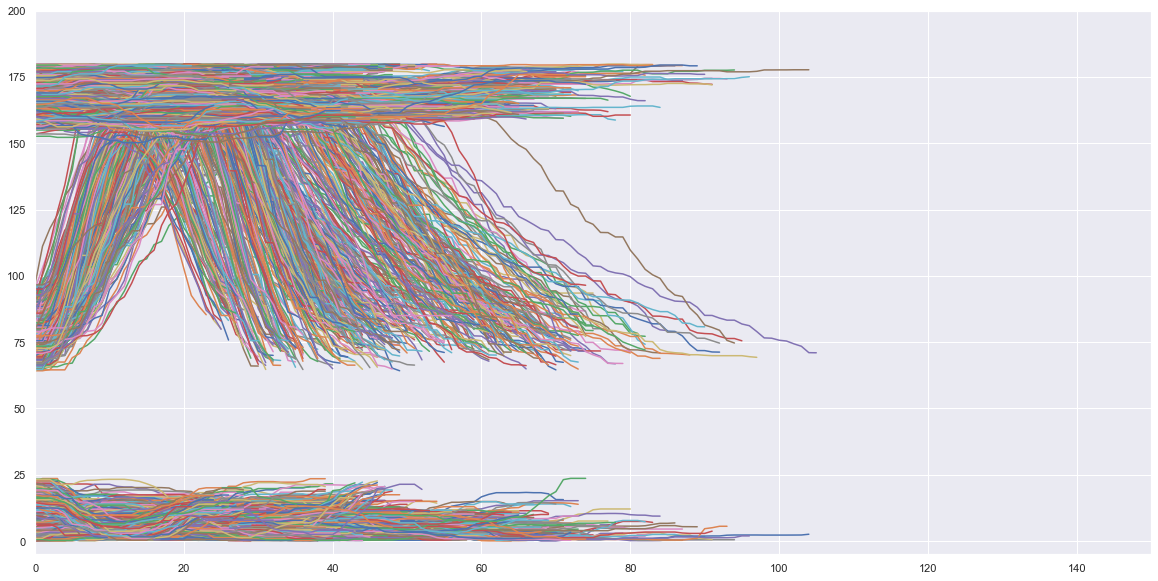

In [303]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance 
import seaborn as sns;sns.set()


ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0, 150)
plt.ylim(-5, 200)
for ts in series:
    ax = sns.lineplot(ax=ax,data=ts, legend=False)

plt.show()


In [ ]:
import scipy.cluster.hierarchy as shc
from dtaidistance import dtw, clustering
font = {'weight' : 'bold',
        'size'   : 20}
new_df = df[df['Label'] == 0]
plt.rc('font', **font)
plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
Z = shc.linkage(numpy_fillna(new_df['Angle_array'].values),  method='single', metric=dtw.distance_fast)
dend = shc.dendrogram(Z, leaf_font_size=8.)

In [12]:
from sklearn.cluster import AgglomerativeClustering
from dtaidistance import dtw, clustering


#ts_df = to_time_series_dataset(series)
#print(ts_df)

ds2_good = dtw.distance_matrix_fast(series)
#print(ds2)
ds2_good[ds2_good == np.inf] = 0


In [13]:
cluster_good = AgglomerativeClustering(n_clusters=3, affinity='precomputed',  linkage='single') #distance_threshold=182.)  
pred_good = cluster_good.fit_predict(ds2_good)


In [13]:
cluster_good.n_clusters_

3

In [14]:
df_good['new_labels'] = cluster_good.labels_

In [15]:
clusters_num1 = np.sort(np.unique(cluster_good.labels_))

for n in clusters_num1:
    np_ls = np.array([])
    vs = df_good[df_good['new_labels'] == n].Angle_array.values
    
    print(n, np.append(np_ls, vs).size)
    #print(len(clusters_arrays))


0 565
1 519
2 808


In [16]:
cluster_ut_df_good = df_good[df_good['new_labels'] == 0].reset_index(drop=True)
cluster_uf_df_good = df_good[df_good['new_labels'] == 1].reset_index(drop=True)
cluster_tk_df_good = df_good[df_good['new_labels'] == 2].reset_index(drop=True)
#cluster3_df = new_df[new_df['new_labels'] == 3]

print(cluster_ut_df_good.head())
print(cluster_uf_df_good.head())
print(cluster_tk_df_good.head())
#print(cluster3_df.head())


                                         Angle_array  Label  new_labels
0  [12.492020774347218, 12.492020774347218, 12.49...      0           0
1  [14.41168152188108, 15.145721551859719, 15.145...      0           0
2  [12.363995874074773, 12.363995874074773, 12.27...      0           0
3  [13.158830214650166, 13.158830214650166, 12.67...      0           0
4  [11.00732435121932, 11.00732435121932, 11.0073...      0           0
                                         Angle_array  Label  new_labels
0  [94.52428256779325, 94.52428256779325, 97.5730...      0           1
1  [95.8773111975647, 95.8773111975647, 99.663043...      0           1
2  [89.32800468158571, 89.32800468158571, 89.5034...      0           1
3  [86.12571966492459, 86.12571966492459, 91.5572...      0           1
4  [88.14053112833021, 88.14053112833021, 93.9143...      0           1
                                         Angle_array  Label  new_labels
0  [173.55197279771207, 173.55197279771207, 173.5...      0     

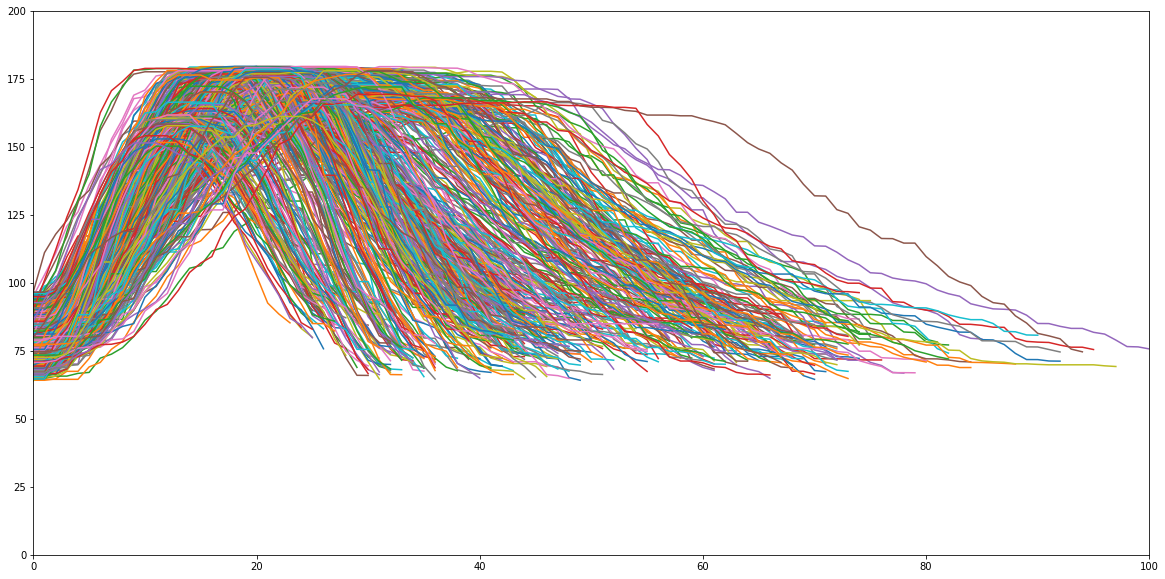

In [17]:
import seaborn as sns
ax = None
plt.figure(figsize=(20, 10))
plt.xlim(0,100)
plt.ylim(0,200)
for ts in cluster_uf_df_good.Angle_array.values:
    #print(ts)
    ax = sns.lineplot(ax=ax,data=ts)
    
plt.show()


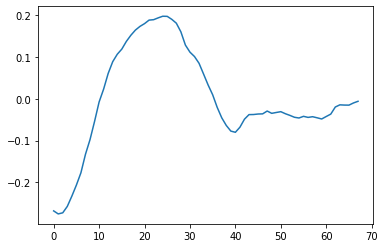

In [67]:
test_df = numpy_fillna(tk_df_bad.Angle_array.values)
test_df[test_df==0] = np.nan

sns.lineplot(data=shape_extraction(test_df))

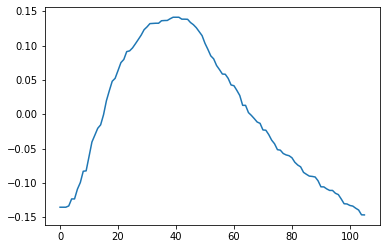

In [271]:
sns.lineplot(data=gt)
plt.show()

In [343]:
uf_df_good['Angle_array'] = uf_df_good['Angle_array'].apply(lambda x: zscore(x))

In [228]:
X_good = uf_df_good.Angle_array.values

In [23]:
X_bad = uf_df_bad.Angle_array.values

In [19]:
X_good = numpy_fillna(uf_df_good.Angle_array.values)


In [521]:
X_good[X_good==0] = np.nan


In [86]:
def make_equal_length(x, y):
    if x.size > y.size:
        n = x.size - y.size
        y = np.pad(y, (0,n), 'constant', constant_values=np.nan)

    elif x.size < y.size:
        n = y.size - x.size 
        x = np.pad(x, (0,n), 'constant', constant_values=np.nan)
    
    return x, y
    
    

In [179]:
dtw.distance(X_bad[0], X_good[45])

74.49227858002136

In [229]:
X_good[50][-1:]

array([79.24129822])

In [96]:
X_good[0][-1:]

array([95.8773112])

349.62064275316965


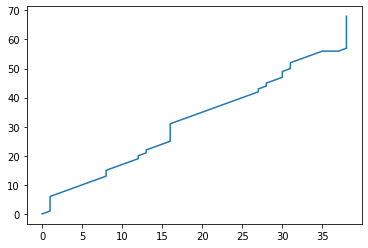

In [175]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

d, s = fastdtw(X_good[0], X_good[45], dist=euclidean)
print(d)
plt.plot(*zip(*s))
plt.show()

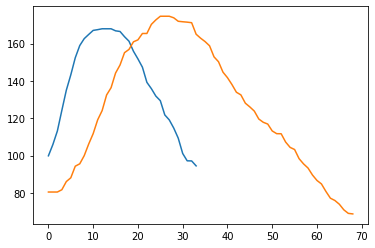

In [178]:
sns.lineplot(data=X_bad[0])
sns.lineplot(data=X_good[45])

In [137]:
X_bad[43][:1]

array([75.66629506])

0.15524601496678525 [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan  99.92144583 105.98385102
 113.21233004 124.2399689  135.03154812 143.260415   152.4168619
 158.938566   162.64627665 164.89187028 167.0575591  167.45238578
 167.92355621 167.92355621 167.92355621 166.82743644 166.47430706
 163.68846556 161.27737963 155.88427096 151.79700247]


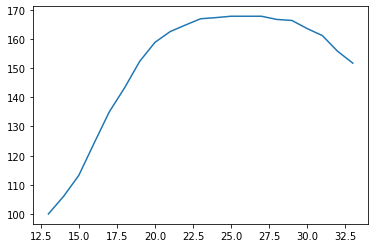

In [177]:
#x,y = make_equal_length(X_good[0],tk_df_bad.Angle_array.values[50])
d, s =_sbd(X_good[45], X_bad[0])
s[s==0] = np.nan
print(d,s)
sns.lineplot(data=s)

In [189]:
similar_length_df = []
for n in range(X_good.size):
    if n+1 == X_good.size:
        break
    s1 = X_good[n]
    s2 = X_good[n+1]
    
    if abs(s1.size - s2.size) < 6:
        similar_length_df.extend((s1,s2))

similar_length_df = np.array(similar_length_df)
    

[[94.52428257 94.52428257 97.57302292 ...         nan         nan
          nan]
 [95.8773112  95.8773112  99.66304318 ...         nan         nan
          nan]
 [95.8773112  95.8773112  99.66304318 ...         nan         nan
          nan]
 ...
 [74.72121865 74.72121865 75.16998911 ...         nan         nan
          nan]
 [67.11579443 67.11579443 68.80869519 ...         nan         nan
          nan]
 [72.62376221 72.62376221 72.70026788 ...         nan         nan
          nan]]


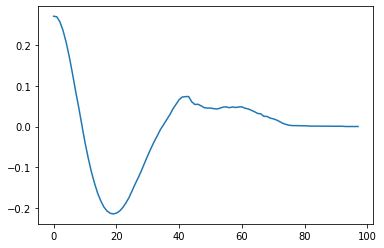

In [195]:
sns.lineplot(data=shape_extraction(similar_length_df))

In [185]:
X_good.size

519

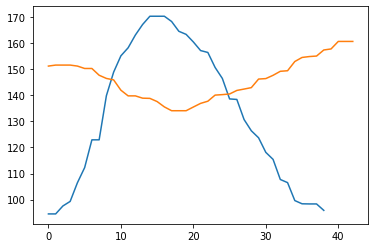

In [62]:
sns.lineplot(data=X_good[0], legend='brief')
sns.lineplot(data=tk_df_bad.Angle_array.values[50])

In [34]:
X_good[0][:1]

array([94.52428257])

In [35]:
X_bad[0][:1]

array([99.92144583])

In [511]:
X_good[0].std()

nan

In [546]:
import sys

np.set_printoptions(threshold=sys.maxsize)

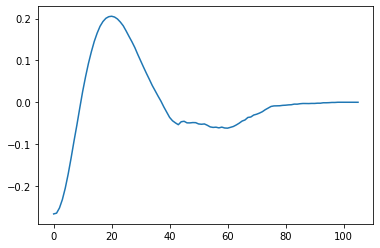

In [589]:
sns.lineplot(data=shape_extraction(X_good))

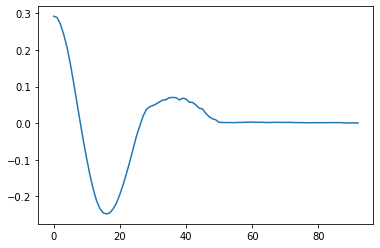

In [590]:
sns.lineplot(data=shape_extraction(Y))

In [96]:
n.shape

(519, 106)

In [219]:
if gt.size > n[0].size:
        num = gt.size - n.size
        n = np.pad(n, (0,num), 'constant', constant_values=np.nan)
elif gt.size < n.size:
    num = n.size - gt.size
    gt = np.pad(gt, (0,num), 'constant', constant_values=np.nan)


In [446]:
np.array_equal(gt, shape_extraction(n, recurse=101))

C:\Users\kvash\anaconda3\lib\site-packages\kshape\core.py:15: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


False

In [222]:
from numpy.linalg import norm, eigh
from kshape.core import _sbd, zscore
import math
from pprint import pprint

def shape_extraction(x, recurse=101, curr_center=None):
    _a = []   
    
    if curr_center is None:
        curr_center = np.array([])
    
    for i in range(x.shape[0]):
        if curr_center.sum() == 0:
            opt_x = x[i]
        else:
            _, opt_x = _sbd(curr_center, x[i])
        _a.append(opt_x)
    a = np.array(_a)
  
    if len(a) == 0:
        print("Algo X' is []")
        return np.zeros((1, x.shape[1]))
            
    columns = a.shape[1]
    y = zscore2(a)
    s = np.dot(y.transpose(), y)
    
    p = np.empty((columns, columns))
    p.fill(1.0/columns)
    p = np.eye(columns) - p
    
    m = np.dot(np.dot(p, s), p)
    _, vec = eigh(m)
    centroid = vec[:, -1]
    finddistance1 = math.sqrt(((a[0] - centroid) ** 2).sum())
    finddistance2 = math.sqrt(((a[0] + centroid) ** 2).sum())

    if finddistance1 >= finddistance2:
        centroid *= -1
    #print(centroid)
    # recursion
    if recurse < 101:
        recurse += 1
        centroid = shape_extraction(x, recurse, centroid)

    #return zscore(centroid, ddof=1)
    return centroid


In [199]:
def get_global_trajectory(cluster):
    trajectory= []
    mean = []
    std = []
    
    #global trajectory
    gt = shape_extraction(cluster, recurse=101)
    
    for ts in cluster:
        shape = shape_extraction(np.array([ts, gt]), recurse=101)
        trajectory.append(shape)
       
    for p in range(gt.size):
        all_ps = []
        for s in trajectory:
            all_ps.append(s[p])
               
        m = np.mean(all_ps)
        st = np.std(all_ps)
        mean.append(m)
        std.append(st)
    
    return gt, mean, std , trajectory 
        
    
    

In [586]:
np.nan_to_num(np.array([1,2,4,np.nan]))

array([1., 2., 4., 0.])

In [583]:
zscore(X, axis=1).shape

(519, 106)

In [576]:
np.array([[1,2,3], [8,2,3]])/ np.expand_dims(np.array([2]), axis=1)

array([[0.5, 1. , 1.5],
       [4. , 1. , 1.5]])

In [575]:
np.expand_dims(np.array([2,4]), axis=1)

array([[2],
       [4]])

In [564]:
np.array([2]).shape

(1,)

In [443]:
cluster_uf_df_good['Angle_array'] = cluster_uf_df_good['Angle_array'].apply(lambda x: zscore(x))

In [196]:
X = cluster_uf_df_good.Angle_array

In [445]:
X = numpy_fillna(X)

In [446]:
X[X==0] = np.nan

In [197]:
X[0]

array([ 94.52428257,  94.52428257,  97.57302292,  99.31493361,
       106.45326799, 112.26485377, 122.89735369, 122.90216939,
       139.81163169, 148.83217698, 155.07194901, 158.15812084,
       163.04896241, 167.08583782, 170.23943547, 170.23943547,
       170.23943547, 168.22376264, 164.473273  , 163.30195328,
       160.38788093, 157.09084883, 156.36906427, 150.63360955,
       146.41952696, 138.56968999, 138.3699588 , 130.67030048,
       126.36806169, 123.68577187, 118.09469302, 115.41357689,
       107.71131191, 106.51373549,  99.63606497,  98.39995641,
        98.34768178,  98.34460314,  95.8773112 ])

Get global trajectories for each cluster

In [208]:
gt, mean, std, ls = get_global_trajectory(X)


ValueError: operands could not be broadcast together with shapes (39,) (106,) 

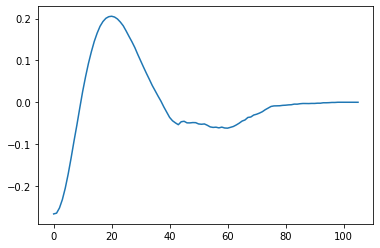

In [594]:
sns.lineplot(data=gt)

In [595]:
X[0]

array([-1.40679975, -1.40679975, -1.2929827 , -1.22795285, -0.9614611 ,
       -0.74450017, -0.34756254, -0.34738276,  0.28388946,  0.62064882,
        0.853595  ,  0.96880946,  1.15139672,  1.30210331,  1.41983494,
        1.41983494,  1.41983494,  1.34458487,  1.20456977,  1.1608415 ,
        1.05205194,  0.92896555,  0.90201954,  0.68790077,  0.5305786 ,
        0.23752469,  0.23006823, -0.05737914, -0.21799239, -0.31812893,
       -0.52685779, -0.62695052, -0.9144952 , -0.9592037 , -1.21596422,
       -1.26211122, -1.26406276, -1.2641777 , -1.35628783,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [123]:
print(len(mean), gt.size, len(std))

106 106 106


In [597]:
mean = np.array(mean)
std = np.array(std)

In [652]:
detect_bad_form(X_good[100],gt,mean,std)

True

In [640]:
def detect_bad_form(test_ts, gt, mean, std):
    if gt.size > test_ts.size:
        n = gt.size - test_ts.size
        test_ts = np.pad(test_ts, (0,n), 'constant', constant_values=np.nan)

    elif gt.size < test_ts.size:
        n = test_ts.size - gt.size 
        gt = np.pad(gt, (0,n), 'constant', constant_values=np.nan)
    
    shape = shape_extraction(np.array([test_ts, gt]), recurse=101)
    #print(shape)
    for p in range(shape.size):
        if shape[p] > mean[p] + 3*std[p] or shape[p] < mean[p] - 3*std[p]:
            return True

    return False

Testing detect bad form algo

In [598]:
uf_df_bad["Angle_array"] = uf_df_bad["Angle_array"].apply(lambda x: zscore(x))

In [599]:
Y = uf_df_bad.Angle_array.values

In [600]:
Y = numpy_fillna(Y)

In [601]:
Y[Y==0] = np.nan

In [602]:
Y[2]

array([-1.3679612 , -1.07813077, -0.78834438, -0.49880349, -0.20106046,
        0.0403516 ,  0.42963534,  0.67803696,  0.85869022,  0.96831739,
        1.29755056,  1.37817892,  1.37817892,  1.37817892,  1.3141034 ,
        1.30781016,  1.27241856,  1.00954577,  0.95266416,  0.71791117,
        0.59751282,  0.39610125,  0.30852903,  0.10195911,  0.01550635,
       -0.26267933, -0.36363053, -0.59318905, -0.71813338, -0.97144667,
       -1.12507794, -1.23435721, -1.34689085, -1.3813812 , -1.38340754,
       -1.41529661, -1.67139   ,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [611]:
sns.lineplot(data=shape_extraction(np.array([Y[0], gt])))

IndexError: tuple index out of range

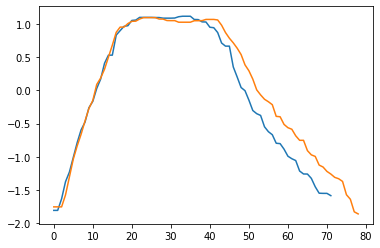

In [504]:
sns.lineplot(data=X_good[9])
sns.lineplot(data=X_good[8])

In [255]:
distances = []
ss1 = []
ss2 = []
for n in range(X_good.size):
    if n + 1 == X_good.size:
        break
    s1 = X_good[n]
    s2 = X_good[n+1]
    if dtw.distance(s1, s2) == 100.49997772893649:
        ss1.append(s1)
        ss2.append(s2)
    distances.append(dtw.distance(s1, s2))
    

In [253]:
print('Max distance between correct ts:', max(distances))
print('Min distance between correct ts:', min(distances))

Max distance between correct ts: 100.49997772893649
Min distance between correct ts: 9.140150642584697


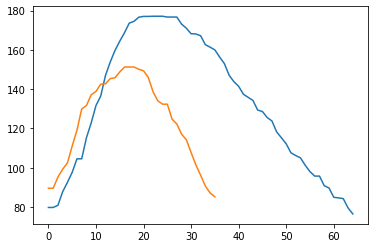

In [258]:
sns.lineplot(data=ss1[0])
sns.lineplot(data=ss2[0])

In [254]:
distances

[18.196954479036826,
 18.67104466271319,
 12.240275308182156,
 14.343077914144493,
 21.234198575583385,
 24.17183570933824,
 30.78699611699995,
 17.589314253112903,
 17.46180115866535,
 17.808741540540545,
 15.773264240837625,
 13.777229067373785,
 16.886775882073074,
 23.766208697661117,
 55.969839832277586,
 41.046519300684714,
 15.044215127475423,
 11.642622940260045,
 16.521932668738877,
 20.583715425252763,
 24.56740844171261,
 20.33817229075204,
 18.472391205212094,
 20.078428192408445,
 69.41825034206674,
 17.692819377425856,
 12.927468579964668,
 11.647731300515387,
 14.435606180096395,
 14.030002513122652,
 12.253072598217297,
 11.61478932645089,
 12.105456440093398,
 15.471609587433994,
 13.726918333730392,
 36.5049995657173,
 11.82171187544796,
 11.287880969937863,
 13.217869327787335,
 17.18243274839032,
 12.782527272991885,
 27.268514587175872,
 47.26360454066727,
 25.352181403657795,
 29.775333565525166,
 35.489916127282015,
 23.89907080746926,
 46.50932631688969,
 75.122

In [251]:
dtw.distance(X_good[9], X_good[8])

17.46180115866535

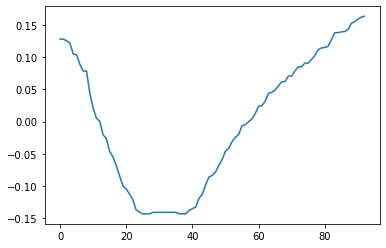

In [148]:
sns.lineplot(data=shape_extraction(Y, recurse=101))

In [613]:
X_good[100]

array([ 69.96665738,  69.96665738,  70.36450997,  71.43664599,
        73.03241677,  74.51810252,  78.33302749,  85.30234716,
        92.26315365,  98.32782659, 103.09796756, 109.64811872,
       116.73184182, 120.73637363, 125.0415304 , 126.44247687,
       133.42277576, 136.87847239, 141.54934745, 141.55156771,
       145.75591394, 148.9626965 , 153.73326377, 155.0056168 ,
       158.60255169, 160.98741751, 162.19586347, 164.84471238,
       165.8984319 , 165.90572518, 166.6308525 , 167.15204663,
       167.15204663, 167.15204663, 167.15204663, 166.5257032 ,
       166.51773989, 164.10407468, 163.8872431 , 163.00905173,
       162.21850954, 160.12099535, 158.57381864, 156.12154318,
       152.95875385, 147.97319331, 147.9712582 , 135.75071677,
       132.34534666, 128.97687521, 124.22292459, 123.97904417,
       119.59956613, 117.99346057, 112.40512194, 112.23537296,
       106.20437467, 104.0662546 ,  99.26569352,  97.20192826,
        93.29037333,  91.45114222,  88.67881441,  87.66

In [604]:
count = 0
for m in X_good:
    if detect_bad_form(m,gt,mean,std):
        count += 1
        print('detected ', count)
    else:
        print('Nope')

C:\Users\kvash\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


detected  1
detected  2
detected  3
detected  4
detected  5
detected  6
detected  7
detected  8
detected  9
detected  10
detected  11
detected  12
detected  13
detected  14
detected  15
detected  16
detected  17
detected  18
detected  19
detected  20
detected  21
detected  22
detected  23
detected  24
detected  25
detected  26
detected  27
detected  28
detected  29
detected  30
detected  31
detected  32
detected  33
detected  34
detected  35
detected  36
detected  37
detected  38
detected  39
detected  40
detected  41
detected  42
detected  43
detected  44
detected  45
detected  46
detected  47
detected  48
detected  49
detected  50
detected  51
detected  52
detected  53
detected  54
detected  55
detected  56
detected  57
detected  58
detected  59
detected  60
detected  61
detected  62
detected  63
detected  64
detected  65
detected  66
detected  67
detected  68
detected  69
detected  70
detected  71
detected  72
detected  73
detected  74
detected  75
detected  76
detected  77
detected

Testing K-Shape clustering

# Timeseries Classification

In [164]:
df = pd.concat([uf_df_good, uf_df_bad, ut_df_good, ut_df_bad, tk_df_good, tk_df_bad]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  2016 non-null   object
 1   Label        2016 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.6+ KB


In [43]:
df = pickle.load( open( "datasets/triceps_df.pickle", "rb" ) )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  2019 non-null   object
 1   Label        2019 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.7+ KB


In [165]:
s1 = pd.Series(x_test, name='Angle_array')
s1a = pd.Series(y_test, name='Label')
df_test = pd.concat([s1,s1a], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Angle_array  861 non-null    object
 1   Label        861 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.6+ KB


In [166]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [167]:
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from tslearn.utils import to_time_series_dataset

# shuffle df
df = df.sample(frac=1).reset_index(drop=True)

y_train = df['Label']
X_train = df['Angle_array']
X_train = numpy_fillna(X_train)
X_train[X_train==0] = np.nan

X_test = numpy_fillna(np.array(x_test))
X_test[X_test==0] = np.nan
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)

(2016, 323)
(861, 101)


In [74]:
type(X_test)

numpy.ndarray

In [138]:
X_test = np.delete(X_test, [0], 0)

In [140]:
y_test = np.delete(y_test, [0])

In [141]:
y_test.size

880

In [144]:
X_test.shape

(880, 101)

In [168]:
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
#knn_clf = KNeighborsClassifier(k, n_jobs=-1)
knn_clf.fit(X_train, y_train)
predicted_labels = knn_clf.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted_labels)
print("Correct classification rate:", acc)
print('\n')
print(metrics.classification_report(y_test, predicted_labels))
print('F1 score:', metrics.f1_score(y_test, predicted_labels, average='macro'))


Correct classification rate: 0.9396051103368177


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       502
           1       0.99      0.86      0.92       359

    accuracy                           0.94       861
   macro avg       0.95      0.93      0.94       861
weighted avg       0.94      0.94      0.94       861

F1 score: 0.9364792009534078


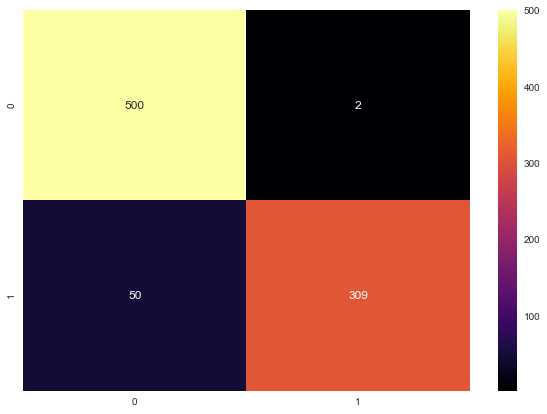

In [169]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cbar=True, fmt='g', cmap='inferno')

In [170]:
confusion_matrix(y_test, predicted_labels)

array([[500,   2],
       [ 50, 309]], dtype=int64)

In [24]:
with open('datasets/triceps_df.pickle', 'wb') as f:
    pickle.dump(df, f)